In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [2]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25 #############
    seed = 42
    neg_ratio = 100 #######
    test_size = 0.2

In [3]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 200
cfg.emb_dim = 256
cfg.layer_dim1 = 512
cfg.layer_dim2 = 512
cfg.dropout = 0.1
cfg.epochs = 50
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [4]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [5]:
# 경로 설정
data_path = './data'
saved_path = './code/saved'
output_path = './code/submission'

In [6]:
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
watch_e_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
search_df =  pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

In [7]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1

cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1

In [8]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


In [9]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))  
for (p, _, i, r) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

100%|███████████████████████████████| 719401/719401 [00:02<00:00, 349380.69it/s]


train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
profile_df = profile_df.set_index('profile_id')

le = LabelEncoder()
profile_df['sex'] = le.fit_transform(profile_df['sex'])
profile_df['pr_interest_keyword_cd_1'] = le.fit_transform(profile_df['pr_interest_keyword_cd_1'])
profile_df['pr_interest_keyword_cd_2'] = le.fit_transform(profile_df['pr_interest_keyword_cd_2'])
profile_df['pr_interest_keyword_cd_3'] = le.fit_transform(profile_df['pr_interest_keyword_cd_3'])
profile_df['ch_interest_keyword_cd_1'] = le.fit_transform(profile_df['ch_interest_keyword_cd_1'])
profile_df['ch_interest_keyword_cd_2'] = le.fit_transform(profile_df['ch_interest_keyword_cd_2'])
profile_df['ch_interest_keyword_cd_3'] = le.fit_transform(profile_df['ch_interest_keyword_cd_3'])

In [11]:
# 유저 특징 정보 추출 
user_features = profile_df[['age', 'sex',
                            'pr_interest_keyword_cd_1',
                            'pr_interest_keyword_cd_2',
                            'pr_interest_keyword_cd_3',
                            'ch_interest_keyword_cd_1',
                            'ch_interest_keyword_cd_2',
                            'ch_interest_keyword_cd_3']].to_dict()

In [12]:
cfg.n_pr_interest_keyword_1 = profile_df['pr_interest_keyword_cd_1'].nunique()
cfg.n_ch_interest_keyword_1 = profile_df['ch_interest_keyword_cd_1'].nunique()
cfg.n_pr_interest_keyword_2 = profile_df['pr_interest_keyword_cd_2'].nunique()
cfg.n_ch_interest_keyword_2 = profile_df['ch_interest_keyword_cd_2'].nunique()
cfg.n_pr_interest_keyword_3 = profile_df['pr_interest_keyword_cd_3'].nunique()
cfg.n_ch_interest_keyword_3 = profile_df['ch_interest_keyword_cd_3'].nunique()


In [13]:
meta_df = meta_df.set_index('album_id')

In [14]:
meta_df['genre_large'] = le.fit_transform(meta_df['genre_large'])
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
meta_df['genre_small'] = le.fit_transform(meta_df['genre_small'])
meta_df['cast_1'] = le.fit_transform(meta_df['cast_1'])
meta_df['cast_2'] = le.fit_transform(meta_df['cast_2'])
meta_df['cast_3'] = le.fit_transform(meta_df['cast_3'])
meta_df['cast_4'] = le.fit_transform(meta_df['cast_4'])
meta_df['cast_5'] = le.fit_transform(meta_df['cast_5'])
meta_df['cast_6'] = le.fit_transform(meta_df['cast_6'])
meta_df['cast_7'] = le.fit_transform(meta_df['cast_7'])

In [15]:
item_features = meta_df[['genre_large', 'genre_mid', 'genre_small',
                         'cast_1', 'cast_2', 'cast_3', 
                         'cast_4', 'cast_5', 'cast_6', 'cast_7']].to_dict()

In [16]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genre_small = meta_df['genre_small'].nunique()
cfg.n_genre_mid = meta_df['genre_mid'].nunique()
cfg.n_genre_large = meta_df['genre_large'].nunique()
cfg.n_cast_1 = meta_df['cast_1'].nunique()
cfg.n_cast_2 = meta_df['cast_2'].nunique()
cfg.n_cast_3 = meta_df['cast_3'].nunique()
cfg.n_cast_4 = meta_df['cast_4'].nunique()
cfg.n_cast_5 = meta_df['cast_5'].nunique()
cfg.n_cast_6 = meta_df['cast_6'].nunique()
cfg.n_cast_7 = meta_df['cast_7'].nunique()

cfg.n_continuous_feats = 1 # 연속형 feature는 나이뿐이니까 하나?

In [17]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim1 = cfg.layer_dim1
        self.layer_dim2 = cfg.layer_dim2
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genre_mid = cfg.n_genre_mid
#         self.n_genre_large = cfg.n_genre_large
        self.n_pr_interest_1 = cfg.n_pr_interest_keyword_1    
        self.n_ch_interest_1 = cfg.n_ch_interest_keyword_1 
        self.n_pr_interest_2 = cfg.n_pr_interest_keyword_2    
        self.n_ch_interest_2 = cfg.n_ch_interest_keyword_2 
        self.n_pr_interest_3 = cfg.n_pr_interest_keyword_3    
        self.n_ch_interest_3 = cfg.n_ch_interest_keyword_3 
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)  #256
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        
        self.sex_embedding = nn.Embedding(num_embeddings=2, embedding_dim=1)
        self.genre_mid_embeddig = nn.Embedding(num_embeddings=self.n_genre_mid, embedding_dim=self.n_genre_mid//2)
#         self.genre_large_embeddig = nn.Embedding(num_embeddings=self.n_genre_large, embedding_dim=self.n_genre_large//2)
        
        
        self.pr_interest_1_embedding = nn.Embedding(num_embeddings=self.n_pr_interest_1, embedding_dim=self.n_pr_interest_1//2)
        self.ch_interest_1_embedding = nn.Embedding(num_embeddings=self.n_ch_interest_1, embedding_dim=self.n_ch_interest_1//2)
        self.pr_interest_2_embedding = nn.Embedding(num_embeddings=self.n_pr_interest_2, embedding_dim=self.n_pr_interest_2//2)
        self.ch_interest_2_embedding = nn.Embedding(num_embeddings=self.n_ch_interest_2, embedding_dim=self.n_ch_interest_2//2)
        self.pr_interest_3_embedding = nn.Embedding(num_embeddings=self.n_pr_interest_3, embedding_dim=self.n_pr_interest_3//2)
        self.ch_interest_3_embedding = nn.Embedding(num_embeddings=self.n_ch_interest_3, embedding_dim=self.n_ch_interest_3//2)
        
        
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim +self.n_genre_mid//2 + self.n_pr_interest_1//2 + self.n_ch_interest_1//2+
                      self.n_pr_interest_2//2 + self.n_ch_interest_2//2+self.n_pr_interest_3//2 + self.n_ch_interest_3//2+
                      self.n_continuous_feats +1, self.layer_dim1), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim1, self.layer_dim2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),
            nn.Linear(self.layer_dim2, self.layer_dim2//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout),
            
        )
        self.affine_output = nn.Linear(self.layer_dim2//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)
#         print(user_embedding_mf.shape)
        item_embedding_mf = self.item_embedding_mf(item_indices)
#         print(item_embedding_mf.shape)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)  # element wise
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_mid_embedding_mlp = self.genre_mid_embeddig(feats[5])
#         genre_large_embedding_mlp = self.genre_large_embeddig(feats[4])
        pr_interest_1_embedding_mlp = self.pr_interest_1_embedding(feats[2])
        ch_interest_1_embedding_mlp = self.ch_interest_1_embedding(feats[3])
        pr_interest_2_embedding_mlp = self.pr_interest_2_embedding(feats[2])
        ch_interest_2_embedding_mlp = self.ch_interest_2_embedding(feats[3])
        pr_interest_3_embedding_mlp = self.pr_interest_3_embedding(feats[2])
        ch_interest_3_embedding_mlp = self.ch_interest_3_embedding(feats[3])
        
        sex_embedding_mlp = self.sex_embedding(feats[1])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp,genre_mid_embedding_mlp,
                                   pr_interest_1_embedding_mlp,ch_interest_1_embedding_mlp,
                                   pr_interest_2_embedding_mlp,ch_interest_2_embedding_mlp,
                                   pr_interest_3_embedding_mlp,ch_interest_3_embedding_mlp,
                                   sex_embedding_mlp,feats[0].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

In [ ]:
import pickle

with open(file='./data/UIdataset.pickle', mode='rb') as f:
    UIdataset = pickle.load(f)

In [21]:
import pickle

with open(file='./data/UIdataset.pickle', mode='rb') as f:
    UIdataset = pickle.load(f)

In [18]:
def make_UIdataset(train, neg_ratio):
    
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = []
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 'age' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['age'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'sex' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['sex'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'pr_interest_keyword_cd_1' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['pr_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'ch_interest_keyword_cd_1' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['ch_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        
        # feature 'pr_interest_keyword_cd_2' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['pr_interest_keyword_cd_2'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'ch_interest_keyword_cd_2' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['ch_interest_keyword_cd_2'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        
        # feature 'pr_interest_keyword_cd_3' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['pr_interest_keyword_cd_3'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'ch_interest_keyword_cd_3' 
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['ch_interest_keyword_cd_3'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        
        
        
        
#         # feature 'genre_large
#         features = []
#         for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
#             features.append(item_features['genre_large'][item_id])
#         UIdataset[user_id].append(np.array(features))
        
        # feature 'genre_mid'
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(item_features['genre_mid'][item_id])
        UIdataset[user_id].append(np.array(features))
        
        # feature 'cast_1'
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(item_features['cast_1'][item_id])
        #UIdataset[user_id].append(np.array(features))
        
        # feature 'cast_2
        #features = []
        #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        #    features.append(item_features['cast_2'][item_id])
        #UIdataset[user_id].append(np.array(features))
        
        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [19]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [20]:
def make_batchdata(user_indices, batch_idx, batch_size):
    
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_feat2 = []
    batch_feat3 = []
    batch_feat4 = []
    batch_feat5 = []
    batch_feat6 = []
    batch_feat7 = []
    batch_feat8 = []
    batch_labels = []
    
    for user_id in batch_user_indices:
        
        item_ids = UIdataset[user_id][0] # 시청 아이템 index
        
        feat0 = UIdataset[user_id][1] # 나이
        feat1 = UIdataset[user_id][2] # 성별
        feat2 = UIdataset[user_id][3] # 부모 관심 키워드 1
        feat3 = UIdataset[user_id][4] # 아이 관심 키워드 1
        feat4 = UIdataset[user_id][5] # 부모 관심 키워드 2
        feat5 = UIdataset[user_id][6] # 아이 관심 키워드 2
        feat6 = UIdataset[user_id][7] # 부모 관심 키워드 3
        feat7 = UIdataset[user_id][8] # 아이 관심 키워드 3
        
        
#         feat4 = UIdataset[user_id][5] # 대분류 장르
        feat8 = UIdataset[user_id][9] # 중분류 장르
        #feat6 = UIdataset[user_id][7] # 출연 캐릭터 1
        #feat7 = UIdataset[user_id][8] # 출연 캐릭터 2
        
        labels = UIdataset[user_id][10] # 평점
        
        user_ids = np.full(len(item_ids), user_id)
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())
        batch_feat5.extend(feat5.tolist())
        batch_feat6.extend(feat6.tolist())
        batch_feat7.extend(feat7.tolist())
        batch_feat8.extend(feat8.tolist())
        
        batch_labels.extend(labels.tolist())
        
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, batch_feat3, batch_feat4, batch_feat5, batch_feat6, batch_feat7,batch_feat8, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

In [21]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, feat2, feat3, feat4, feat5,feat6,feat7,feat8, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        
        feat0 = torch.FloatTensor(feat0).to(cfg.device) # 나이: 연속형 -> FloatTensor
        
        # Long Tensor
        feat1 = torch.LongTensor(feat1).to(cfg.device) # 성별
        feat2 = torch.LongTensor(feat2).to(cfg.device) # 부모 관심 키워드 1
        feat3 = torch.LongTensor(feat3).to(cfg.device) # 아이 관심 키워드 1   
        feat4 = torch.LongTensor(feat4).to(cfg.device) # 부모 관심 키워드 2
        feat5 = torch.LongTensor(feat5).to(cfg.device) # 아이 관심 키워드 2   
        feat6 = torch.LongTensor(feat6).to(cfg.device) # 부모 관심 키워드 3
        feat7 = torch.LongTensor(feat7).to(cfg.device) # 아이 관심 키워드 3   
        feat8 = torch.LongTensor(feat8).to(cfg.device) # 중분류 장르
        
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [22]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
#     full_item_ids_feat4 = [item_features['genre_large'][c] for c in full_item_ids]
    full_item_ids_feat8 = [item_features['genre_mid'][c] for c in full_item_ids]
    #full_item_ids_feat6 = [item_features['cast_1'][c] for c in full_item_ids]
    #full_item_ids_feat7 = [item_features['cast_2'][c] for c in full_item_ids]
    
    for user_id in tqdm(query_user_ids):
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            # 사용자 feature
            feat0 = np.full(cfg.n_items, user_features['age'][user_id]) # age
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            
            feat1 = np.full(cfg.n_items, user_features['sex'][user_id]) # sex
            feat1 = torch.LongTensor(feat1).to(cfg.device)
            
            feat2 = np.full(cfg.n_items, user_features['pr_interest_keyword_cd_1'][user_id]) # 부모 관심 키워드 1
            feat2 = torch.LongTensor(feat2).to(cfg.device)
            
            feat3 = np.full(cfg.n_items, user_features['ch_interest_keyword_cd_1'][user_id]) # 아이 관심 키워드 1
            feat3 = torch.LongTensor(feat3).to(cfg.device)
            
            feat4 = np.full(cfg.n_items, user_features['pr_interest_keyword_cd_2'][user_id]) # 부모 관심 키워드 1
            feat4 = torch.LongTensor(feat4).to(cfg.device)
            
            feat5 = np.full(cfg.n_items, user_features['ch_interest_keyword_cd_2'][user_id]) # 아이 관심 키워드 1
            feat5 = torch.LongTensor(feat5).to(cfg.device)
            
            feat6 = np.full(cfg.n_items, user_features['pr_interest_keyword_cd_3'][user_id]) # 부모 관심 키워드 1
            feat6 = torch.LongTensor(feat6).to(cfg.device)
            
            feat7 = np.full(cfg.n_items, user_features['ch_interest_keyword_cd_3'][user_id]) # 아이 관심 키워드 1
            feat7 = torch.LongTensor(feat7).to(cfg.device)
            
            # 아이템 feature
            feat8 = torch.LongTensor(full_item_ids_feat8).to(cfg.device)
#             feat5 = torch.LongTensor(full_item_ids_feat5).to(cfg.device)
            #feat6 = torch.LongTensor(full_item_ids_feat6).to(cfg.device)
            #feat7 = torch.LongTensor(full_item_ids_feat7).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

In [23]:
def recallk(actual, predicted, k = 25):
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))]) 
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [24]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.91)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

In [25]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    scheduler.step()
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(best_scores).pth'))

100%|██████████████████████████████████████| 7299/7299 [00:48<00:00, 149.77it/s]


Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  13173.350590  0.158116  0.120946  0.001028  0.148823


100%|██████████████████████████████████████| 7299/7299 [00:48<00:00, 148.98it/s]


01  7705.744630  0.228653  0.180817  0.014771  0.216694


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 148.42it/s]


02  6132.616210  0.379210  0.283465  0.069066  0.355273


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 147.21it/s]


03  4450.313960  0.458924  0.338074  0.160251  0.428712


100%|██████████████████████████████████████| 7299/7299 [00:50<00:00, 144.15it/s]


04  3106.927000  0.477806  0.351633  0.209555  0.446263


100%|██████████████████████████████████████| 7299/7299 [00:50<00:00, 145.72it/s]


05  2140.560550  0.493072  0.359502  0.265705  0.459679


100%|██████████████████████████████████████| 7299/7299 [00:50<00:00, 145.91it/s]


06  1523.190190  0.499398  0.364084  0.284589  0.465569


100%|██████████████████████████████████████| 7299/7299 [00:50<00:00, 145.64it/s]


07  1124.025510  0.501751  0.364867  0.314458  0.467530


100%|██████████████████████████████████████| 7299/7299 [00:50<00:00, 145.69it/s]


08  862.582210  0.501139  0.363880  0.332614  0.466824


100%|██████████████████████████████████████| 7299/7299 [00:50<00:00, 145.69it/s]


09  681.794010  0.502227  0.363568  0.335950  0.467562


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.65it/s]


10  547.296630  0.502123  0.364238  0.337254  0.467652


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.53it/s]


11  446.882690  0.502299  0.363762  0.345053  0.467665


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.11it/s]


12  373.229770  0.502470  0.363411  0.343197  0.467705


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.37it/s]


13  318.192990  0.502447  0.362963  0.350495  0.467576


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.20it/s]


14  275.452120  0.501504  0.362370  0.354056  0.466721


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.14it/s]


15  241.684010  0.501614  0.362628  0.353856  0.466867


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 147.24it/s]


16  214.325910  0.501525  0.362169  0.358270  0.466686


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.71it/s]


17  191.696670  0.500944  0.361966  0.360577  0.466199


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.33it/s]


18  173.738370  0.501534  0.361993  0.358997  0.466649


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.65it/s]


19  158.006680  0.500776  0.361629  0.362608  0.465989


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.85it/s]


20  144.650650  0.500949  0.361617  0.361354  0.466116


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.43it/s]


21  133.550990  0.500548  0.361429  0.364966  0.465769


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.89it/s]


22  124.083600  0.499749  0.361096  0.367674  0.465086


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.93it/s]


23  115.618430  0.500218  0.361103  0.367373  0.465439


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.88it/s]


24  108.290090  0.499873  0.360912  0.367875  0.465133


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.24it/s]


25  101.960940  0.499954  0.360794  0.369429  0.465164


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.44it/s]


26  96.341420  0.499907  0.360854  0.370056  0.465143


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.07it/s]


27  91.365730  0.499938  0.360826  0.370031  0.465160


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.80it/s]


28  87.078870  0.499656  0.360498  0.370558  0.464867


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.80it/s]


29  83.016320  0.499310  0.360468  0.371210  0.464599


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.67it/s]


30  79.512890  0.499604  0.360522  0.371661  0.464833


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.63it/s]


31  76.248740  0.499718  0.360528  0.372088  0.464920


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.67it/s]


32  73.354950  0.499556  0.360315  0.372790  0.464746


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.46it/s]


33  70.847270  0.499487  0.360468  0.371285  0.464732


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.80it/s]


34  68.615660  0.499418  0.360411  0.372389  0.464666


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.82it/s]


35  66.477780  0.499512  0.360397  0.372614  0.464734


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.52it/s]


36  64.493160  0.499475  0.360243  0.373768  0.464667


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.85it/s]


37  62.870740  0.499281  0.360309  0.373818  0.464538


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.87it/s]


38  61.110590  0.499282  0.360230  0.373342  0.464519


100%|██████████████████████████████████████| 7299/7299 [00:49<00:00, 146.83it/s]


39  59.708360  0.499397  0.360325  0.374495  0.464629


RuntimeError: CUDA out of memory. Tried to allocate 718.00 MiB (GPU 0; 10.75 GiB total capacity; 7.01 GiB already allocated; 512.75 MiB free; 8.55 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

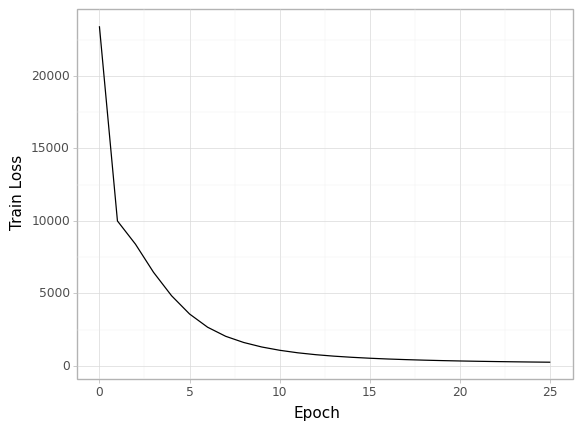

<ggplot: (8728495256182)>

In [29]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [30]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

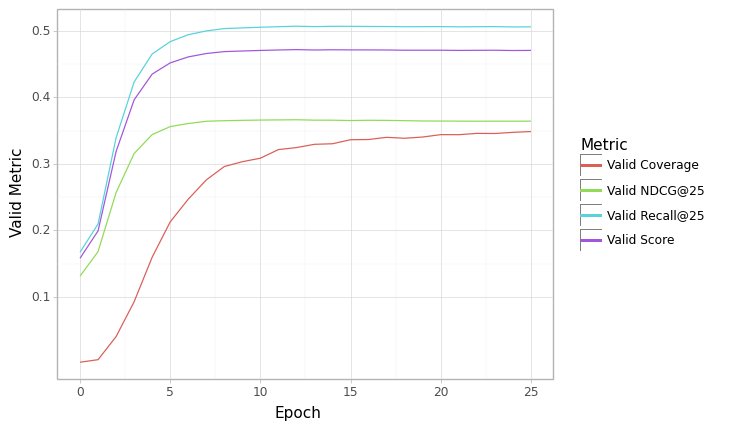

<ggplot: (8728495256173)>

In [31]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

In [32]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(best_scores).pth')))

<All keys matched successfully>

In [33]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

100%|██████████████████████████████████████| 8311/8311 [00:35<00:00, 233.57it/s]


In [34]:
submission.to_csv(os.path.join(output_path, 'submission_2.csv'), index = False)